# Data exploration for city of Bremen

## Import required packages

In [79]:
import datetime
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
from shapely.ops import cascaded_union
from tqdm import tqdm

## Import raw data

In [2]:
raw_data = pd.read_csv('../data/raw/bremen.csv')
raw_data.drop(columns=['Unnamed: 0'], inplace=True) # Drop second index column
raw_data.sample()

p_spot  p_place_type             datetime  b_number   trip   p_uid  \
2186298    True             0  2019-11-28 21:46:00     54138  start  264394   

         p_bikes      p_lat  b_bike_type                             p_name  \
2186298       44  48.994617           71  Hauptbahnhof / Touristinformation   

         p_number     p_lng  p_bike  
2186298    5400.0  8.400361   False

## Filter data for entrys of Bremen only
https://github.com/gboeing/urban-data-science/blob/master/19-Spatial-Analysis-and-Cartography/rtree-spatial-indexing.ipynb

### Import geodata of Bremen (PLZ based)

https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/table/?refine.note=Bremen

In [3]:
plz_df = gpd.read_file('../data/external/plz_bremen.geojson')

In [4]:
# Function that creates map with center such that all of Bremen is displayed.

def create_bremen_map(zoom = 11):
    
    m = folium.Map(location=[53.122962,8.7515937], zoom_start=zoom)
    
    return m

In [5]:
geo_data_bremen = create_bremen_map()

folium.Choropleth(plz_df).add_to(geo_data_bremen)

geo_data_bremen

### Get "boundaries" (min, max of latitude and longitude) of Bremen

In [6]:
boundaries = cascaded_union(plz_df.geometry).bounds
boundaries

(8.4815929, 53.0110367, 8.9907318, 53.22892479999999)

### Filter raw data such that we only keep data points within the boundaries of Bremen
- has to be done in preprocessor

#### Coarse filtering first for faster computation

In [7]:
bremen = raw_data[(raw_data['p_lat'] < boundaries[3]) &
         (raw_data['p_lat'] > boundaries[1]) &
         (raw_data['p_lng'] < boundaries[2])  &
         (raw_data['p_lng'] > boundaries[0])]

print(len(bremen))

1309128


## Total number of null values

- there are only null values (88) of the attribute p_number

In [8]:
bremen.isna().sum()

p_spot           0
p_place_type     0
datetime         0
b_number         0
trip             0
p_uid            0
p_bikes          0
p_lat            0
b_bike_type      0
p_name           0
p_number        88
p_lng            0
p_bike           0
dtype: int64

### Drop null values
- has to be done in preprocessor

In [9]:
bremen = bremen.dropna()

### Create geopandas data frame

In [10]:
bremen = gpd.GeoDataFrame(bremen, geometry=gpd.points_from_xy(bremen.p_lng.copy(), bremen.p_lat.copy()))

### Precise filtering for data points within Bremen

In [11]:
bremen = gpd.sjoin(bremen, plz_df[['geometry','plz']], how='left', op = 'within')

/home/janik/.local/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


#### Drop index of plz df and drop data points that are outside of Bremen borders

In [12]:
bremen = bremen.drop(columns=['index_right']).dropna()

## Reorder data frame
- has to be done in preprocessor

In [13]:
bremen = bremen[['datetime', 'b_number', 'p_spot', 'p_place_type',
                 'trip', 'p_uid', 'p_bikes', 'b_bike_type', 'p_name',
                 'p_number', 'p_bike', 'p_lat', 'p_lng','geometry', 'plz']]

# First explorations

## Total number of bookings (data points)

In [14]:
len(bremen)

1279878

## Total number of bikes - 443
- there are 443 different bikes presented in our data
- WESER-KURIER announced to provide 450 https://www.nextbike.de/de/news/start-fuer-wk-bike-in-bremen/

In [15]:
print(len(bremen.b_number.unique()))
print(bremen.b_number.unique())

443
[20668 20649 20964 20866 20799 20676 20855 20707 20815 20891 20721 20894
 20958 20942 20635 20838 20889 20827 20793 20797 20748 20791 20713 20790
 20810 20881 20817 20614 20768 20693 20626 20946 20915 20788 20684 20902
 20816 20704 20736 20912 20907 20769 20876 20943 20872 20924 20716 20968
 20761 20686 20804 20703 20967 20916 20756 20709 20725 20918 20903 20702
 20930 20688 20819 20690 20938 20843 20727 20874 20849 20651 20742 20751
 20658 20648 20904 20846 20697 20929 20669 20789 20859 20928 20854 20835
 20800 20771 20833 20937 20839 20935 20794 20715 20893 20621 20747 20900
 20667 20957 20712 20625 20657 20856 20888 20617 20766 20864 20724 20645
 20851 20805 20939 20921 20844 20731 20722 20934 20837 20719 20842 20899
 20734 20698 20616 20682 20743 20802 20735 20917 20858 20887 20798 20673
 20678 20932 20706 20896 20677 20806 20730 20732 20773 20630 20739 20679
 20687 20784 20647 20822 20832 20825 20738 20650 20685 20962 20906 20803
 20696 20922 20913 20670 20961 20963 20848 2084

### For a specific bike (b_number = 20668) check trips
- there seem to be many duplicates

In [16]:
bremen[bremen.b_number == 20668].sort_values('datetime')[:20]

datetime  b_number  p_spot  p_place_type   trip     p_uid  \
2241283  2019-01-20 00:00:00     20668   False            12  first  12097754   
2913437  2019-01-20 00:00:00     20668   False            12  first  12097754   
2241284  2019-01-20 01:33:00     20668   False            12   last  12097754   
2913438  2019-01-20 01:33:00     20668   False            12   last  12097754   
2242946  2019-01-22 09:15:00     20668    True             0  first   7873316   
2915100  2019-01-22 09:15:00     20668    True             0  first   7873316   
2242947  2019-01-22 09:42:00     20668    True             0  start   7873316   
2915101  2019-01-22 09:42:00     20668    True             0  start   7873316   
2242948  2019-01-22 09:49:00     20668   False            12    end  12155136   
2915102  2019-01-22 09:49:00     20668   False            12    end  12155136   
2242949  2019-01-22 14:52:00     20668   False            12  start  12155136   
2915103  2019-01-22 14:52:00     20668   False            12  start  12155136   
2242950  2019-01-22 15:35:00     20668   False            12    end  12162204   
2915104  2019-01-22 15:35:00     20668   False            12    end  12162204   
2915105  2019-01-22 23:59:00     20668   False            12   last  12162204   
2242951  2019-01-22 23:59:00     20668   False            12   last  12162204   
2916043  2019-01-23 00:00:00     20668   False            12  first  12162204   
2243889  2019-01-23 00:00:00     20668   False            12  first  12162204   
2916044  2019-01-23 10:42:00     20668   False            12   last  12162204   
2243890  2019-01-23 10:42:00     20668   False            12   last  12162204   

         p_bikes  b_bike_type                         p_name  p_number  \
2241283        1           71                     BIKE 20668       0.0   
2913437        1           71                     BIKE 20668       0.0   
2241284        1           71                     BIKE 20668       0.0   
2913438        1           71                     BIKE 20668       0.0   
2242946        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2915100        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2242947        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2915101        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2242948        1           71                     BIKE 20668       0.0   
2915102        1           71                     BIKE 20668       0.0   
2242949        1           71                     BIKE 20668       0.0   
2915103        1           71                     BIKE 20668       0.0   
2242950        1           71                     BIKE 20668       0.0   
2915104        1           71                     BIKE 20668       0.0   
2915105        1           71                     BIKE 20668       0.0   
2242951        1           71                     BIKE 20668       0.0   
2916043        1           71                     BIKE 20668       0.0   
2243889        1           71                     BIKE 20668       0.0   
2916044        1           71                     BIKE 20668       0.0   
2243890        1           71                     BIKE 20668       0.0   

         p_bike      p_lat     p_lng                  geometry    plz  
2241283    True  53.081698  8.812411  POINT (8.81241 53.08170)  28195  
2913437    True  53.081698  8.812411  POINT (8.81241 53.08170)  28195  
2241284    True  53.081767  8.812408  POINT (8.81241 53.08177)  28195  
2913438    True  53.081767  8.812408  POINT (8.81241 53.08177)  28195  
2242946   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2915100   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2242947   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2915101   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2242948    True  53.080356  8.795718  POINT (8.79572 53.08036)  28195  
2915102    True  53.080356  8.795718  POINT

## Check for duplicates

In [17]:
# Checking for duplicates regarding the timestamp and bike_number 
bremen.duplicated(subset=['datetime', 'b_number']).sum()

639939

## Drop duplicates - half of data (there is perfectly one duplicate per data point)
- has to be done in preprocessor

In [18]:
bremen = bremen[bremen.duplicated(subset=['datetime', 'b_number'], keep='first') == False]

In [19]:
len(bremen)

639939

## Specifications of p_bikes
- number of available bikes at position/station

In [20]:
bremen.p_bikes.unique()

array([ 1,  2,  3,  5,  4,  0,  7,  6,  8,  9, 11, 10, 12, 15, 14, 13, 16,
       17, 31, 30, 32, 28, 20, 25, 26, 18, 23, 21, 27, 22, 29, 19])

## Specifications of b_bike_type
- two different types of bikes

In [21]:
bremen.b_bike_type.unique()

array([71, 29])

## Specifications of p_bike
- if True in flex zone and not at station
- opposite of p_spot

In [22]:
bremen.p_bike.unique()


array([ True, False])

## Specifications of p_spot
- at fixed station area
- if True there is a p_name (name of fixed station)
- opposite of p_bike

In [23]:
bremen.p_spot.unique()

array([False,  True])

## Total number of p_uid
- unique ids of start and end locations
- includes 76 out of 83 ids of fixed stations

In [24]:
bremen.p_uid.nunique()

156809

- 76 out of 83 fixed stations are present in our data

In [25]:
len(bremen[bremen.p_spot == True].p_uid.unique())

73

## Import station data

In [26]:
stations = json_normalize(pd.read_json('../data/external/station_information.json').iloc[0,2])
stations.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


station_id                       name short_name        lat       lon  \
0    2351602  WESER-KURIER | Pressehaus       2910  53.076722  8.803943   
1    7872668                  Am Dobben       2925  53.078194  8.823250   
2    7872701             Am Speicher XI       2926  53.097556  8.770056   

  region_id  capacity  
0       379       5.0  
1       379       NaN  
2       379       NaN

In [27]:
len(stations) # number of fixed stations

83

## Specifications of p_name
- name of start/end location
- partly contains weird names like coordinates

In [28]:
bremen.p_name.nunique()

5955

In [29]:
bremen[bremen.p_name.str[:4] != 'BIKE'].p_name.unique()

array(['WeserTower', 'Pusdorfer Marktplatz', 'GEWOBA | Ludwig-Beck 2a',
       ..., ' Faulenstraße 65', '53.082872, 8.812058',
       'recording_91000056'], dtype=object)

## Total number of p_number
- short ids for fixed stations
- 0 if not at fixed station but in flex zone

In [30]:
print(len(bremen.p_number.unique()))
print(bremen.p_number.unique())

76
[    0.  2971.  2959.  2988.  2927.  2910.  2933.  2972.  2912.  2941.
  2938.  2949.  2913.  2976.  2985.  2928. 29860.  2929.  2970.  2936.
  2986.  2946.  2952.  2963.  2967.  2975.  2966.  2947.  2958.  2940.
  2945.  2962.  2961.  2969.  2987.  2937.  2930.  2965.  2934.  2957.
  2950.  2939.  2942.  2911.  2951.  2955.  2925.  2990.  2932.  2931.
  2926.  2948.  2944.  2992.  2956.  2954.  2991.  2935.  2914.  2997.
  2977.  2964.  2974.  2960.  2973.  2968.  2989.  2915.  2916.  2917.
  2919.  2918.  2920.  2923.  2922.  2921.]


## Specifications of p_bikes
- number of available bikes at position/station

In [31]:
bremen.p_bikes.unique()

array([ 1,  2,  3,  5,  4,  0,  7,  6,  8,  9, 11, 10, 12, 15, 14, 13, 16,
       17, 31, 30, 32, 28, 20, 25, 26, 18, 23, 21, 27, 22, 29, 19])

In [32]:
bremen[bremen.p_spot == False].p_bikes.max() # can there be more than one bike if not in flex zone - yes

2

## Specifications of trip
- [start, end, first, last]  (do not refer to duplicates)
- more specific analysis of trip attribute in the creation process of trips down below

In [33]:
bremen.trip.unique()

array(['first', 'last', 'start', 'end'], dtype=object)

In [34]:
len(bremen[(bremen.trip != 'first') & (bremen.trip != 'last')])

454796

In [35]:
bremen['datetime'] = pd.to_datetime(bremen['datetime']) # parse timestamp to datetime

### Sort data frame by timestamp
- has to be done in preprocessor

In [36]:
bremen = bremen.sort_values('datetime')

In [37]:
bremen[bremen.b_number == 20668][:20]

datetime  b_number  p_spot  p_place_type   trip     p_uid  \
2241283 2019-01-20 00:00:00     20668   False            12  first  12097754   
2241284 2019-01-20 01:33:00     20668   False            12   last  12097754   
2242946 2019-01-22 09:15:00     20668    True             0  first   7873316   
2242947 2019-01-22 09:42:00     20668    True             0  start   7873316   
2242948 2019-01-22 09:49:00     20668   False            12    end  12155136   
2242949 2019-01-22 14:52:00     20668   False            12  start  12155136   
2242950 2019-01-22 15:35:00     20668   False            12    end  12162204   
2242951 2019-01-22 23:59:00     20668   False            12   last  12162204   
2243889 2019-01-23 00:00:00     20668   False            12  first  12162204   
2243890 2019-01-23 10:42:00     20668   False            12   last  12162204   
2246583 2019-01-25 07:46:00     20668    True             0  first   7873007   
2246584 2019-01-25 14:42:00     20668    True             0  start   7873007   
2246585 2019-01-25 14:56:00     20668   False            12    end  12232480   
2246586 2019-01-25 23:59:00     20668   False            12   last  12232480   
2247504 2019-01-26 00:00:00     20668   False            12  first  12232480   
2247505 2019-01-26 23:59:00     20668   False            12   last  12232480   
2248252 2019-01-27 00:00:00     20668   False            12  first  12232480   
2248253 2019-01-27 23:59:00     20668   False            12   last  12232480   
2248957 2019-01-28 00:00:00     20668   False            12  first  12232480   
2248958 2019-01-28 06:42:00     20668   False            12  start  12232480   

         p_bikes  b_bike_type                         p_name  p_number  \
2241283        1           71                     BIKE 20668       0.0   
2241284        1           71                     BIKE 20668       0.0   
2242946        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2242947        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2242948        1           71                     BIKE 20668       0.0   
2242949        1           71                     BIKE 20668       0.0   
2242950        1           71                     BIKE 20668       0.0   
2242951        1           71                     BIKE 20668       0.0   
2243889        1           71                     BIKE 20668       0.0   
2243890        1           71                     BIKE 20668       0.0   
2246583        4           71                      Domsheide    2933.0   
2246584        4           71                      Domsheide    2933.0   
2246585        1           71                     BIKE 20668       0.0   
2246586        1           71                     BIKE 20668       0.0   
2247504        1           71                     BIKE 20668       0.0   
2247505        1           71                     BIKE 20668       0.0   
2248252        1           71                     BIKE 20668       0.0   
2248253        1           71                     BIKE 20668       0.0   
2248957        1           71                     BIKE 20668       0.0   
2248958        1           71                     BIKE 20668       0.0   

         p_bike      p_lat     p_lng                  geometry    plz  
2241283    True  53.081698  8.812411  POINT (8.81241 53.08170)  28195  
2241284    True  53.081767  8.812408  POINT (8.81241 53.08177)  28195  
2242946   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2242947   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2242948    True  53.080356  8.795718  POINT (8.79572 53.08036)  28195  
2242949    True  53.080453  8.795549  POINT (8.79555 53.08045)  28195  
2242950    True  53.062169  8.875182  POINT (8.87518 53.06217)  28207  
2242951    True  53.061929  8.875118  POINT (8.87512 53.06193)  28207  
2243889    True  53.061929  8.875118  POINT (8.87512 53.06193)  28207  
2243890    True  53.062032  8.875321  POINT (8.87532 53.06203) 

In [38]:
bremen[(bremen.b_number == 20668) & ((bremen.trip == 'first') & (bremen.datetime.dt.hour != 0))]

datetime  b_number  p_spot  p_place_type   trip     p_uid  \
2242946 2019-01-22 09:15:00     20668    True             0  first   7873316   
2246583 2019-01-25 07:46:00     20668    True             0  first   7873007   
2264984 2019-02-11 13:24:00     20668    True             0  first   7873893   
2311718 2019-02-28 14:19:00     20668   False            12  first  13051288   
2313106 2019-03-01 16:45:00     20668   False            12  first  13075883   
2348561 2019-03-19 09:28:00     20668   False            12  first  13428348   
2356371 2019-03-25 10:56:00     20668    True             0  first   8638942   
2369451 2019-04-01 06:33:00     20668   False            12  first  13917223   
2441464 2019-04-30 08:29:00     20668    True             0  first   7873316   
2445210 2019-05-01 03:51:00     20668    True             0  first   7873316   
2448107 2019-05-03 01:21:00     20668   False            12  first  15279482   
2462564 2019-05-10 05:53:00     20668    True             0  first   7873316   
2470775 2019-05-14 05:44:00     20668   False            12  first  15719683   
2493370 2019-05-24 11:26:00     20668    True             0  first   8806578   
2496349 2019-05-25 02:26:00     20668   False            12  first  16231426   
2577137 2019-06-25 07:38:00     20668   False            12  first  17977555   
2585326 2019-06-29 11:36:00     20668    True             0  first   7873781   
2589275 2019-08-01 06:25:00     20668   False            12  first  19874152   
2712527 2019-09-19 16:19:00     20668    True             0  first  10278729   
2754009 2019-10-09 06:11:00     20668    True             0  first   7873316   
2761804 2019-10-13 10:17:00     20668   False            12  first  23349750   
2795542 2019-10-27 01:00:00     20668   False            12  first  24034886   
2892454 2019-12-18 08:36:00     20668    True             0  first   7873893   
2895961 2019-12-20 08:11:00     20668    True             0  first   7873316   
2901625 2019-12-24 09:25:00     20668    True             0  first   7873316   

         p_bikes  b_bike_type                                    p_name  \
2242946        5           71             Hauptbahnhof / Übersee Museum   
2246583        4           71                                 Domsheide   
2264984        2           71                       Woltmershauser Str.   
2311718        1           71                                BIKE 20668   
2313106        1           71                                BIKE 20668   
2348561        1           71                                BIKE 20668   
2356371        4           71                             Föhrenstraße    
2369451        1           71                      Hamburger Straße 248   
2441464        5           71             Hauptbahnhof / Übersee Museum   
2445210        5           71             Hauptbahnhof / Übersee Museum   
2448107        1           71                                BIKE 20668   
2462564        5           71             Hauptbahnhof / Übersee Museum   
2470775        1           71                                BIKE 20668   
2493370        5           71                       GOP / Steigenberger   
2496349        1           71                                BIKE 20668   
2577137        1           71                                BIKE 20668   
2585326        4           71  Schwachhauser Heerstr. / Kirchbachstr.     
2589275        0           71                                BIKE 20668   
2712527        7           71                     GEWOBA | Heideplatz 1   
2754009        4           71             Hauptbahnhof / Übersee Museum   
2761804        1           71                                BIKE 20668   
2795542        1           71                                BIKE 20668   
2892454        6           71                       Woltmershauser Str.   
2895961       11           71             Hauptbahnhof / Übersee Museum   
2901625        1           71             Hauptbahnhof / Überse

In [39]:
# Visualizes number of trips clustered by locations

def plotDataPoints(latitudes, longitudes, zoom):
    
    # Create map centered at Bremens center
    m = create_bremen_map(zoom=zoom)
    
    marker_cluster = MarkerCluster().add_to(m)
        
    if len(latitudes) != len(longitudes):
        print('latitudes & longitudes must be the same size!')
    
    for i in range(len(latitudes)):
        
        lat = latitudes.iloc[i]
        lng = longitudes.iloc[i]
        
        folium.Circle(
            location=[lat,lng],
            radius=15,
            fill=True
        ).add_to(marker_cluster)
                  
    return m

## Visualization of 40000 randomly choosen data point locations

In [40]:
sample_points = bremen.sample(40000)

In [41]:
plotDataPoints(sample_points['p_lat'], sample_points['p_lng'], zoom=11).save('../reports/figures/samplevis_bremen_clustered.html')

# Creation of trips

Theoretically, each ping (this is what we call a record in the data) of a bike that has the trip attribute **start** should also have a counterpart ping with the attribute **end** and therefore the number of trips can be infered from the number of pings that "start" a trip. Let's check that:

In [113]:
print('start pings:', bremen[bremen['trip'] == 'start'].trip.count())
print('end pings:', bremen[bremen['trip'] == 'end'].trip.count())

start pings: 231134
end pings: 223662


There is a small deviation - keep that in mind, and only register a trip if there is a closing end ping for each start ping!

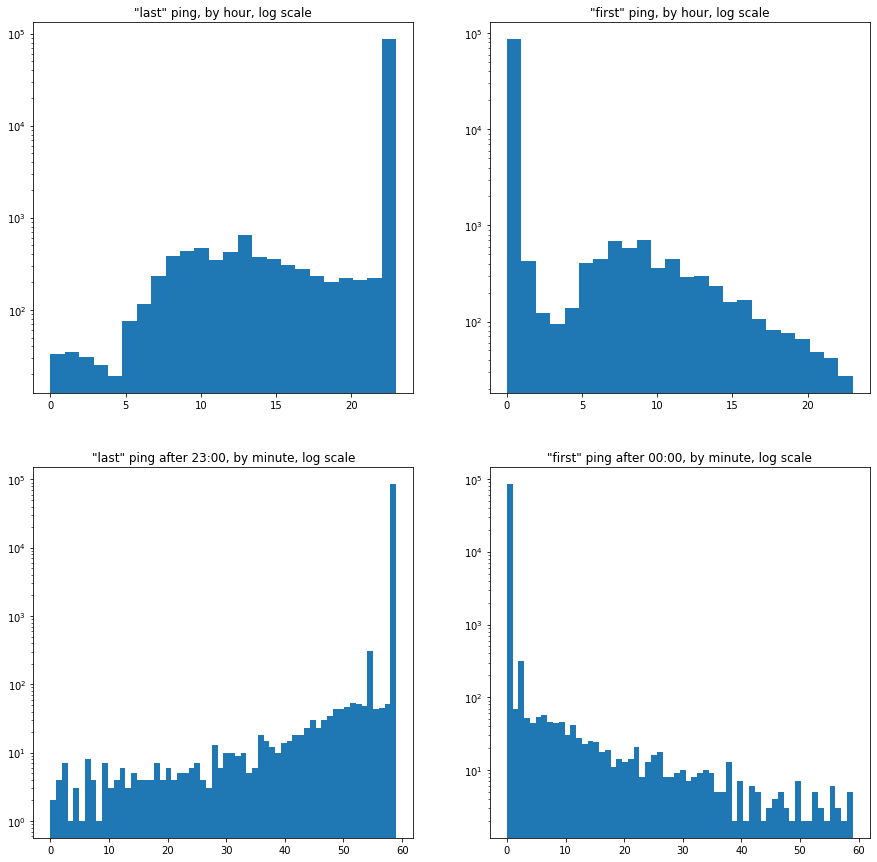

In [114]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0,0].hist(bremen[bremen['trip'] == 'last']['datetime'].dt.hour, bins=24, log=True)
ax[0,0].set_title('"last" ping, by hour, log scale')

ax[1,0].hist(bremen[(bremen['trip'] == 'last') & (bremen['datetime'].dt.hour == 23)]['datetime'].dt.minute, bins=60, log=True)
ax[1,0].set_title('"last" ping after 23:00, by minute, log scale')

ax[0,1].hist(bremen[bremen['trip'] == 'first']['datetime'].dt.hour, bins=24, log=True)
ax[0,1].set_title('"first" ping, by hour, log scale')

ax[1,1].hist(bremen[(bremen['trip'] == 'first') & (bremen['datetime'].dt.hour == 0)]['datetime'].dt.minute, bins=60, log=True)
ax[1,1].set_title('"first" ping after 00:00, by minute, log scale')

plt.show()

Most bikes have their last "ping" at **exactly 23:59** and their first "ping" at **exactly 00:00**.

We can assume these are just status pings that bikes/stations emit when a new day starts.
These can be safely omitted when creating trips. For all other occurrences we can assume these are trips that started on one day and ended on the next.

In [115]:
bremen[bremen['trip'].isin(['start', 'last'])].trip.count()

323763

According to that logic there would be over 300.000 trips - let's have a look.

In [116]:
ordered = bremen.sort_values(['b_number', 'datetime'], axis=0)

trips = []
buffer = None

def write_trip(ping, buffer):
    trip = {'bike': ping['b_number'],
            'bike_type': ping['b_bike_type'],
            'identification': ping['p_uid'],
            'start_time': buffer['datetime'],
            'end_time': ping['datetime'],
            'duration_sec': (ping['datetime'] - buffer['datetime']).total_seconds(),
            'start_lng': buffer['p_lng'],
            'start_lat': buffer['p_lat'],
            'end_lng': ping['p_lng'],
            'end_lat': ping['p_lat'],
            'start_place': buffer['p_number'],
            'end_place': ping['p_number'],
            'start_plz': buffer['plz'],
            'end_plz': ping['plz']
            }

    trips.append(trip)


for index, ping in tqdm(ordered.iterrows(), total=len(ordered), desc='Finished rows:'):

    bike = ping['b_number']
    trip = ping['trip']
    time = ping['datetime']
    lat = ping['p_lat']
    lng = ping['p_lng']

    if buffer is not None:

        buffer_bike = buffer['b_number']
        if bike != buffer_bike:
            # if records of the next bike start, overwrite buffer and continue
            buffer = ping
            continue

        buffer_trip = buffer['trip']
        buffer_time = buffer['datetime']
        buffer_lat = buffer['p_lat']
        buffer_lng = buffer['p_lng']

        if trip == 'first' and buffer_trip == 'last':
            # check for midnight trip
            if buffer_time.time() != datetime.time(23, 59) and time.time() != datetime.time(0, 0):

                # this was not just a checkout/checkin ping
                # now check if the bike has moved
                moved = (lat != buffer_lat) | (lng != buffer_lng)
                if moved:
                    write_trip(ping, buffer)
                    buffer = None

        elif trip == 'end' and buffer_trip == 'start':
            # write trip, discard buffer and continue
            write_trip(ping, buffer)
            buffer = None

        # 
        buffer = ping

    else:
        if trip == 'last' or trip == 'start':
            # only write buffer and start a potential trip with last and start trip attribute
            buffer = ping

trips = pd.DataFrame.from_records(trips)
print('Creating trips from data completed successfully.')

Finished rows:: 100%|██████████| 639939/639939 [05:00<00:00, 2132.13it/s]


Creating trips from data completed successfully.


In [117]:
trips.sample(5)

bike  bike_type  identification          start_time  \
118957  20772         71        17322791 2019-08-06 15:38:00   
152271  20837         71        18282725 2019-06-29 05:11:00   
28306   20575         71        23420197 2019-10-14 15:00:00   
21807   20561         71         7873316 2019-09-10 17:09:00   
117751  20769         71        21614122 2019-09-06 12:22:00   

                  end_time  duration_sec  start_lng  start_lat   end_lng  \
118957 2019-08-06 15:45:00         420.0   8.880113  53.101909  8.880113   
152271 2019-06-29 05:26:00         900.0   8.815771  53.055396  8.805026   
28306  2019-10-14 15:15:00         900.0   8.823682  53.079280  8.873580   
21807  2019-09-10 17:21:00         720.0   8.797378  53.081933  8.811472   
117751 2019-09-06 12:37:00         900.0   8.795301  53.073951  8.780177   

          end_lat  start_place  end_place start_plz end_plz  
118957  53.101909       2922.0     2922.0     28359   28359  
152271  53.079044          0.0        0.0     28201   28195  
28306   53.084391          0.0        0.0     28203   28329  
21807   53.083167          0.0     2946.0     28195   28195  
117751  53.066178          0.0        0.0     28199   28199

In [118]:
print('Actual trips:', len(trips))

Actual trips: 228949


As we can see, there are a lot fewer actual trips, just by removing "trips" that indicate a status ping only (23:59-00:00), and those that do not have correct start and end pings. We still obtain more than 200.000 trips for the given timeframe. Let's look at something we previously did not care about: Roundtrips.

In [119]:
print('There are', trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].bike.count(), 'roundtrips')
print('This equals', trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].bike.count()/ len(trips) * 100, '%')

There are 85872 roundtrips
This equals 37.5070430532564 %


Wow, almost 40% of all trips are round trips, that start and end at **exactly** the same position. Let's look closer into that.

In [120]:
print('do not start/end at a fixed station:')
trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat']) & (trips['start_place'] == 0) & (trips['end_place'] == 0)].bike.count()

do not start/end at a fixed station:


48082

More than 50% of these roundtrips do not start/end at a station, which means the bike would've been rented and returned at exactly the same geo coordinates which is highly unlikely. Let's remove these. -> Add to Preprocessor!

In [121]:
trips = trips[~((trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat']) & (trips['start_place'] == 0) & (trips['end_place'] == 0))]
print('There are', trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].bike.count(), 'roundtrips')
print('This equals', trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].bike.count()/ len(trips) * 100, '%')

There are 37790 roundtrips
This equals 20.893805945805482 %


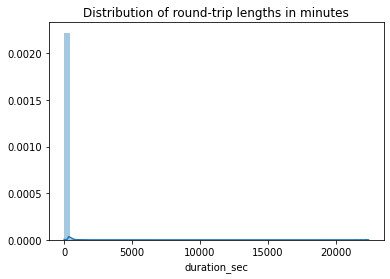

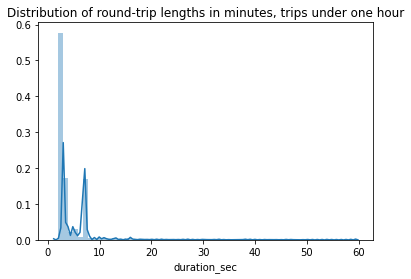

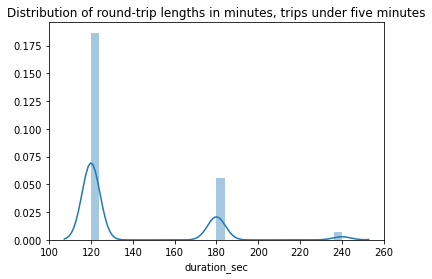

In [122]:
sns.distplot(trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].duration_sec / 60)
plt.title('Distribution of round-trip lengths in minutes')
plt.show()
sns.distplot(trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat']) & (trips['duration_sec'] < 3600)].duration_sec / 60, bins=60)
plt.title('Distribution of round-trip lengths in minutes, trips under one hour')
plt.show()
sns.distplot(trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat']) & (trips['duration_sec'] < 300)].duration_sec)
plt.title('Distribution of round-trip lengths in minutes, trips under five minutes')
plt.show()

As we can see, a huge portion of station-bound roundtrips (those that start and end at exactly the same latitude/longitude) are exactly 120 seconds and 180 seconds long - interesting.

According to https://www.nextbike.de/de/faq/ (see "Das Rahmenschloss öffnet nicht. Was soll ich tun?") a rental that is unsuccessful (because the lock doesn't open e.g.), is automatically returned after 3 minutes - 180 seconds. Bingo! Even though we were not able to find a similar mechanism that acts on the 2 minute (120 seconds) mark, we assume, something similar happens there.

To be sure, we remove roundtrips that are shorter than or equal to 3 minutes - it is highly unlikely that such trips are real.
-> Also add this to the Preprocessor!

In [123]:
trips = trips[trips['duration_sec'] > 180]
print(len(trips), 'trips remain')

149826 trips remain


We conclude, that after preprocessing, we still have almost 150.000 trips that we can work with and be somewhat sure they are real.